In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from scipy.stats import f_oneway, chi2_contingency

# Load dataset
df = pd.read_csv('heart_failure_clinical_records.csv')

# Display first few rows
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,55.0,0,748,0,45,0,263358.03,1.3,137,1,1,88,0
1,65.0,0,56,0,25,0,305000.00,5.0,130,1,0,207,0
2,45.0,0,582,1,38,0,319000.00,0.9,140,0,0,244,0
3,60.0,1,754,1,40,1,328000.00,1.2,126,1,0,90,0
4,95.0,1,582,0,30,0,461000.00,2.0,132,1,0,50,1


In [2]:
# Display the shape of the dataset
print(df.shape)

# Check data types
print(df.dtypes)

# Convert the 'age' column to an integer by rounding it to the nearest whole number
df['age'] = df['age'].round().astype(int)

# Check the result
print(df['age'].unique())

# Check data types
print(df.dtypes)

# Check for missing values
print(df.isnull().sum())

(5000, 13)
age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object
[55 65 45 60 95 70 63 50 53 61 72 64 75 66 58 42 69 68 49 51 44 59 90 46
 80 56 41 85 82 67 52 43 81 48 57 40 86 77 73 62 87 79 47 94 71 78 54]
age                           int32
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smo

Column: age
Q1: 50.0
Q3: 68.0
IQR: 18.0
Lower bound for outliers: 23.0
Upper bound for outliers: 95.0
Number of outliers in age: 0
----------------------------------------


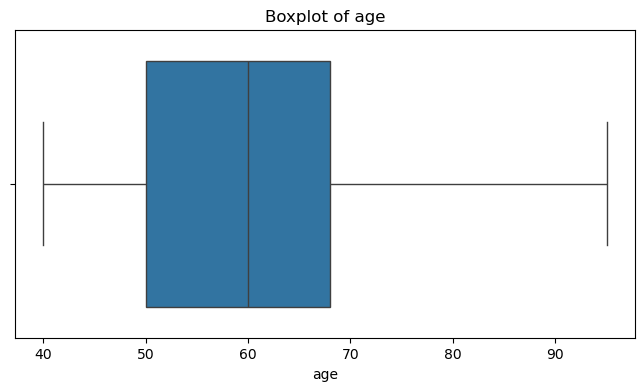

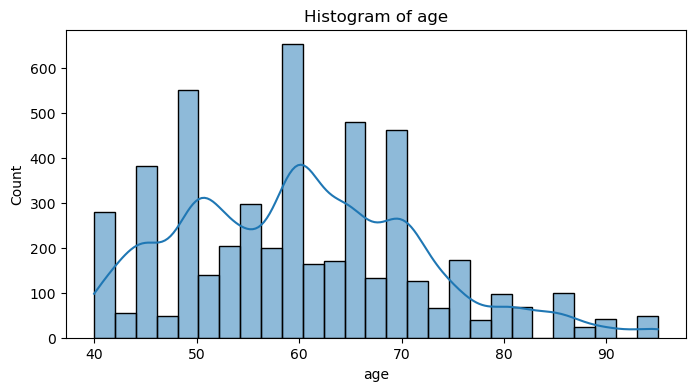

Column: creatinine_phosphokinase
Q1: 121.0
Q3: 582.0
IQR: 461.0
Lower bound for outliers: -570.5
Upper bound for outliers: 1273.5
Number of outliers in creatinine_phosphokinase: 493
----------------------------------------


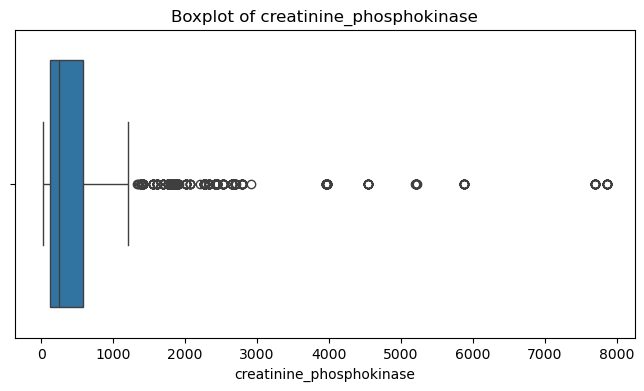

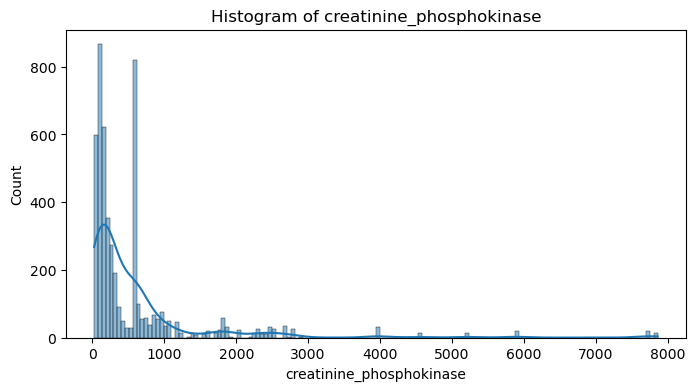

Column: ejection_fraction
Q1: 30.0
Q3: 45.0
IQR: 15.0
Lower bound for outliers: 7.5
Upper bound for outliers: 67.5
Number of outliers in ejection_fraction: 19
----------------------------------------


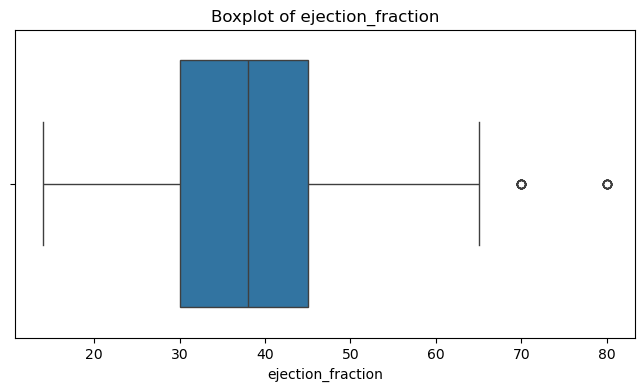

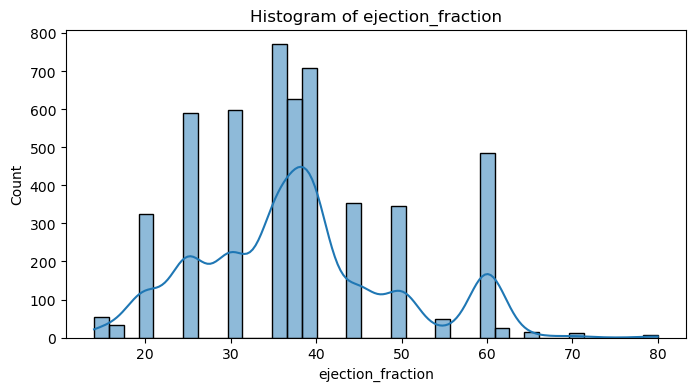

Column: platelets
Q1: 215000.0
Q3: 310000.0
IQR: 95000.0
Lower bound for outliers: 72500.0
Upper bound for outliers: 452500.0
Number of outliers in platelets: 285
----------------------------------------


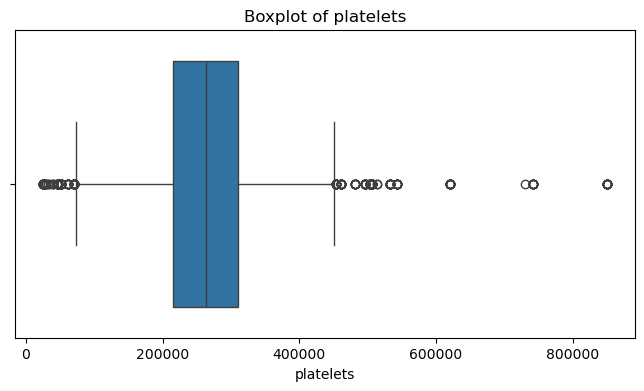

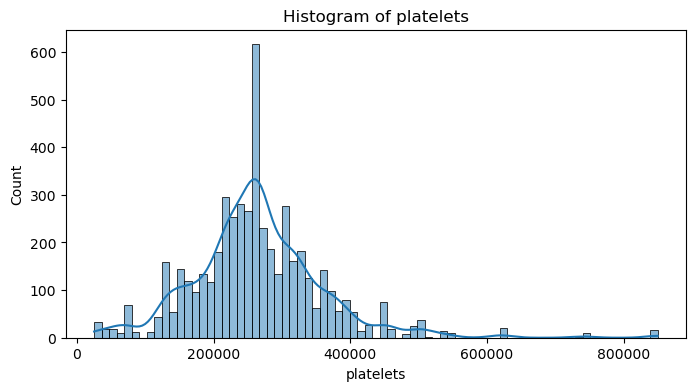

Column: serum_creatinine
Q1: 0.9
Q3: 1.4
IQR: 0.4999999999999999
Lower bound for outliers: 0.15000000000000024
Upper bound for outliers: 2.1499999999999995
Number of outliers in serum_creatinine: 462
----------------------------------------


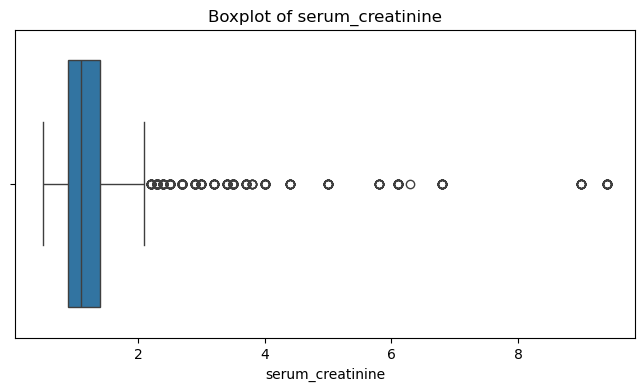

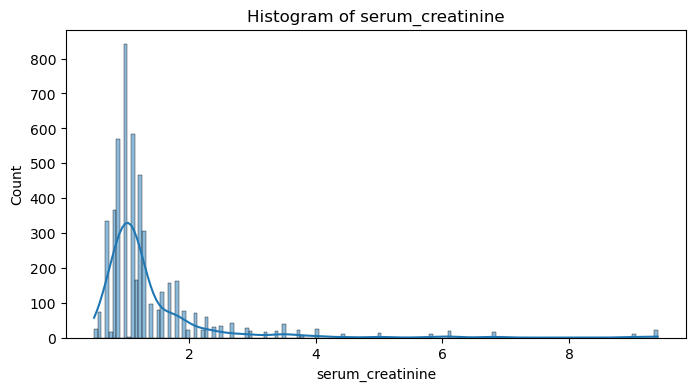

Column: serum_sodium
Q1: 134.0
Q3: 140.0
IQR: 6.0
Lower bound for outliers: 125.0
Upper bound for outliers: 149.0
Number of outliers in serum_sodium: 63
----------------------------------------


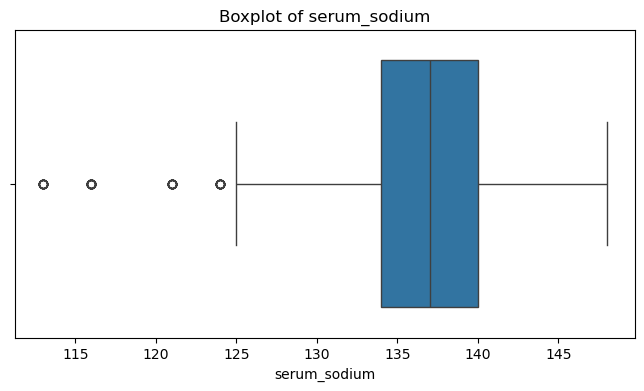

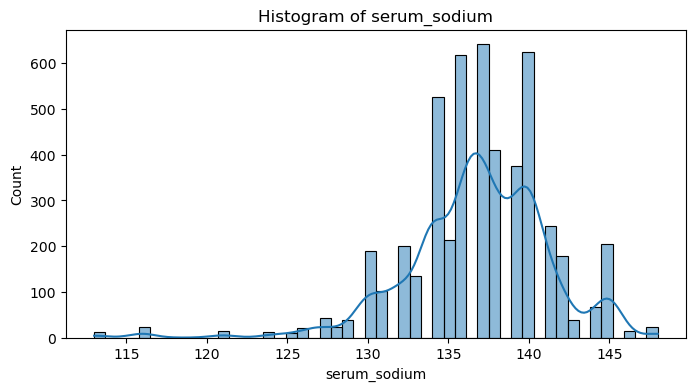

Column: time
Q1: 74.0
Q3: 201.0
IQR: 127.0
Lower bound for outliers: -116.5
Upper bound for outliers: 391.5
Number of outliers in time: 0
----------------------------------------


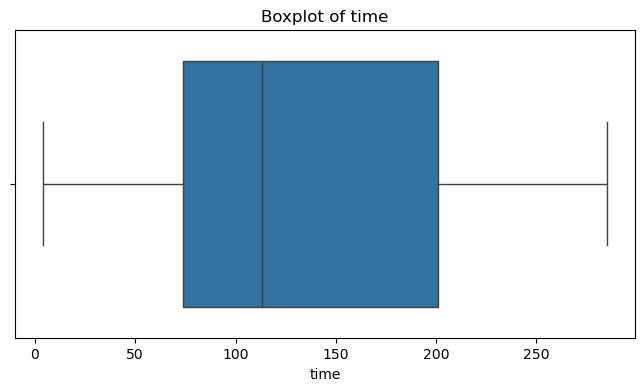

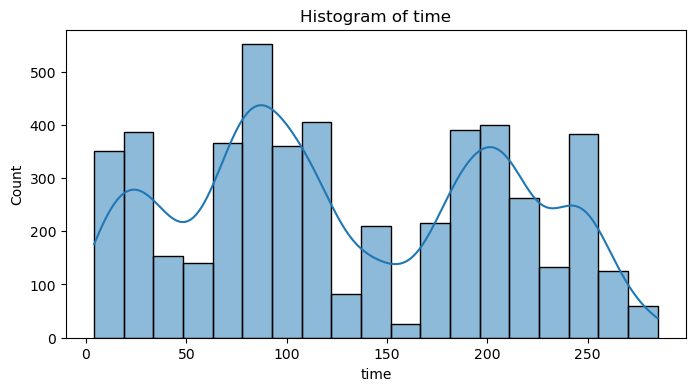

Removing outliers from column: creatinine_phosphokinase
Removing outliers from column: ejection_fraction
Removing outliers from column: platelets
Removing outliers from column: serum_creatinine
Removing outliers from column: serum_sodium
Original dataset shape: (5000, 13)
Cleaned dataset shape: (3786, 13)


In [3]:
# Function to calculate Q1, Q3, IQR, and bounds for outlier detection
def calculate_outlier_bounds(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return Q1, Q3, IQR, lower_bound, upper_bound

# Function to check for outliers and plot boxplot and histogram for a column
def check_and_plot_outliers(df, column):
    Q1, Q3, IQR, lower_bound, upper_bound = calculate_outlier_bounds(df, column)
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    
    print(f"Column: {column}")
    print(f"Q1: {Q1}")
    print(f"Q3: {Q3}")
    print(f"IQR: {IQR}")
    print(f"Lower bound for outliers: {lower_bound}")
    print(f"Upper bound for outliers: {upper_bound}")
    print(f"Number of outliers in {column}: {outliers.count()}")
    print("-" * 40)
    
    # Plot boxplot
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    plt.show()
    
    # Plot histogram
    plt.figure(figsize=(8, 4))
    sns.histplot(df[column], kde=True)
    plt.title(f'Histogram of {column}')
    plt.show()

# Function to remove outliers based on the calculated bounds
def remove_outliers(df, column):
    _, _, _, lower_bound, upper_bound = calculate_outlier_bounds(df, column)
    # Filtering the DataFrame to keep only rows within the bounds
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

# Define the target variable
target_variable = 'DEATH_EVENT'

# Define numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64', 'int32']).columns

# Exclude the target variable from the binary and non-binary column categorization
binary_columns = [col for col in numerical_columns if df[col].nunique() == 2 and col != target_variable]
non_binary_columns = [col for col in numerical_columns if col not in binary_columns and col != target_variable]

# Checking for outliers and plotting for each non-binary column
for column in non_binary_columns:
    check_and_plot_outliers(df, column)

# Remove outliers from all non-binary columns
df_cleaned = df.copy()
for column in non_binary_columns:
    # Check if there are outliers and remove them if necessary
    _, _, _, lower_bound, upper_bound = calculate_outlier_bounds(df, column)
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    if not outliers.empty:
        print(f"Removing outliers from column: {column}")
        df_cleaned = remove_outliers(df_cleaned, column)

# Display the shape of the cleaned dataset
print(f"Original dataset shape: {df.shape}")
print(f"Cleaned dataset shape: {df_cleaned.shape}")

In [4]:
# Checking the distribution of binary columns
for column in binary_columns:
    print(f"\nValue counts for {column}:")
    print(df[column].value_counts())


Value counts for anaemia:
anaemia
0    2628
1    2372
Name: count, dtype: int64

Value counts for diabetes:
diabetes
0    2803
1    2197
Name: count, dtype: int64

Value counts for high_blood_pressure:
high_blood_pressure
0    3176
1    1824
Name: count, dtype: int64

Value counts for sex:
sex
1    3228
0    1772
Name: count, dtype: int64

Value counts for smoking:
smoking
0    3441
1    1559
Name: count, dtype: int64


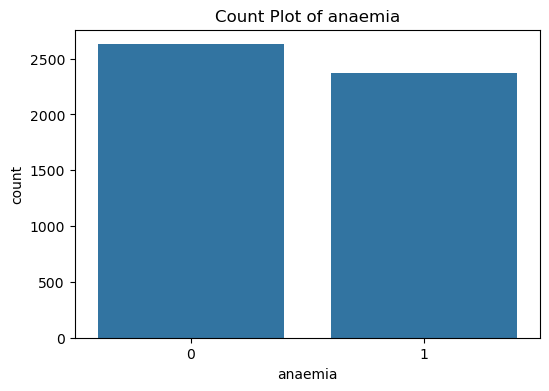

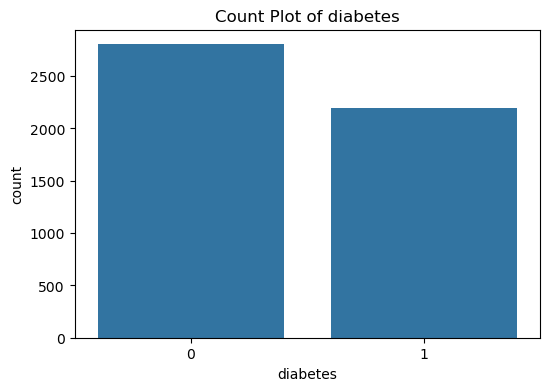

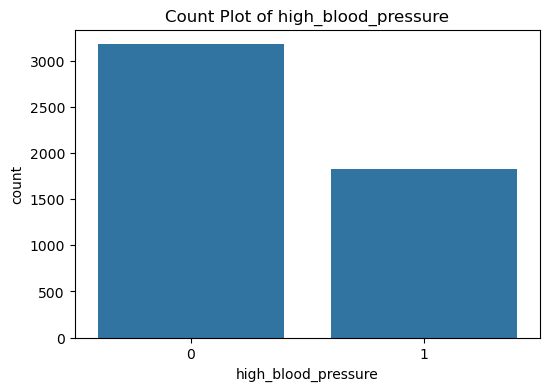

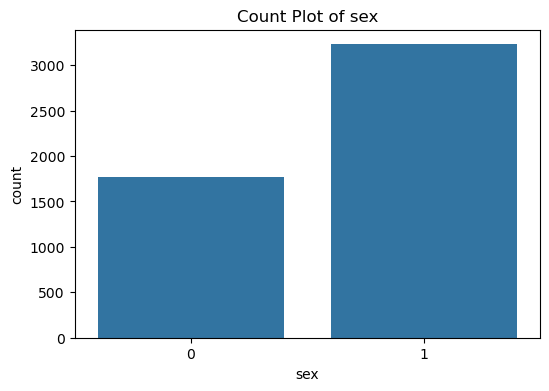

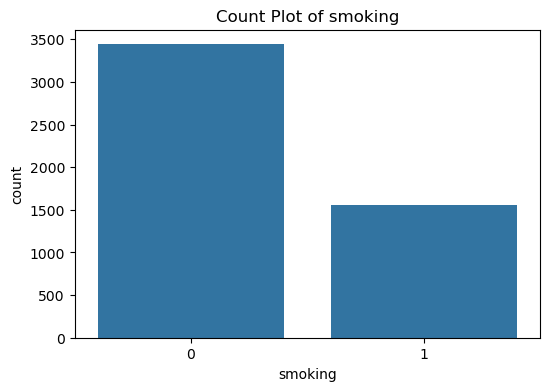

In [5]:
# Count plot for binary columns
for column in binary_columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=df[column])
    plt.title(f"Count Plot of {column}")
    plt.show()

Correlations with DEATH_EVENT:
DEATH_EVENT                 1.000000
serum_creatinine            0.311281
age                         0.249458
high_blood_pressure         0.094023
creatinine_phosphokinase    0.079706
sex                         0.055604
anaemia                     0.054508
smoking                     0.009397
diabetes                   -0.011273
platelets                  -0.031521
serum_sodium               -0.227355
ejection_fraction          -0.292702
time                       -0.527234
Name: DEATH_EVENT, dtype: float64


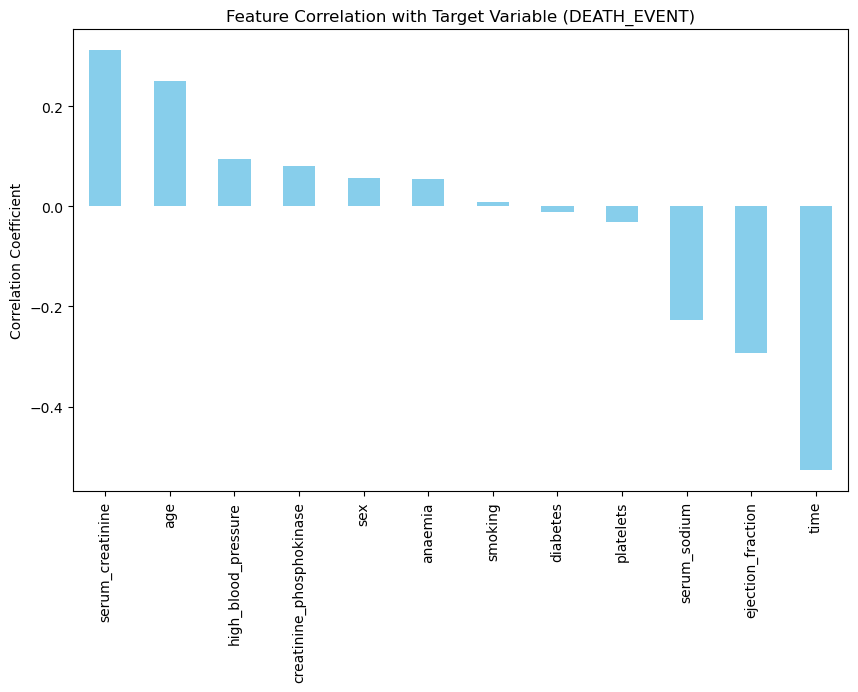

In [6]:
# Calculate correlation with the target variable (DEATH_EVENT)
correlations = df.corr()['DEATH_EVENT'].sort_values(ascending=False)
print("Correlations with DEATH_EVENT:")
print(correlations)

# Visualize correlations using a bar plot
plt.figure(figsize=(10, 6))
correlations.drop('DEATH_EVENT').plot(kind='bar', color='skyblue')
plt.title('Feature Correlation with Target Variable (DEATH_EVENT)')
plt.ylabel('Correlation Coefficient')
plt.show()

In [7]:
# Calculating Point-Biserial Correlation with numerical features
correlations = {}

for column in non_binary_columns:
    correlation, p_value = pointbiserialr(df['DEATH_EVENT'], df[column])
    correlations[column] = correlation

print("\nPoint-Biserial Correlations with DEATH_EVENT:")
for column, corr in correlations.items():
    print(f"{column}: {corr:.4f}")


Point-Biserial Correlations with DEATH_EVENT:
age: 0.2495
creatinine_phosphokinase: 0.0797
ejection_fraction: -0.2927
platelets: -0.0315
serum_creatinine: 0.3113
serum_sodium: -0.2274
time: -0.5272


ANOVA P-Values for Non-Binary Numerical Features:
age: p-value = 0.0000
creatinine_phosphokinase: p-value = 0.0000
ejection_fraction: p-value = 0.0000
platelets: p-value = 0.0258
serum_creatinine: p-value = 0.0000
serum_sodium: p-value = 0.0000
time: p-value = 0.0000


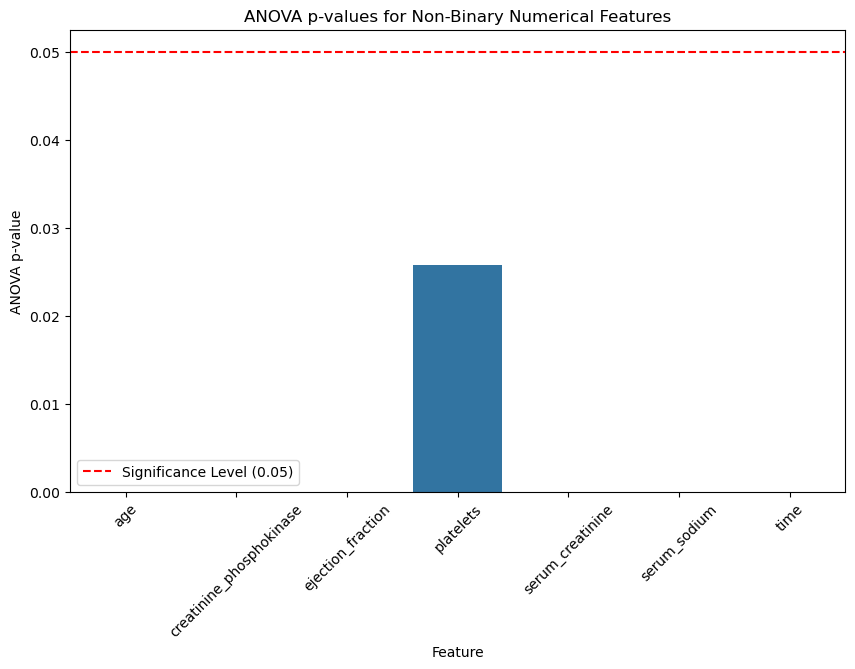


Chi-Square P-Values for Binary Features:
anaemia: p-value = 0.0001
diabetes: p-value = 0.4434
high_blood_pressure: p-value = 0.0000
sex: p-value = 0.0001
smoking: p-value = 0.5277


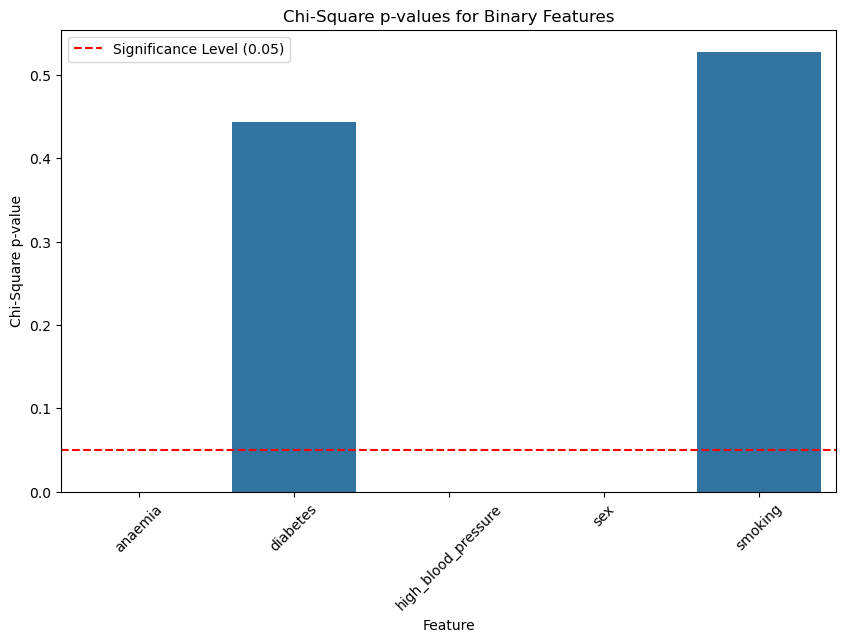

In [8]:
# Analyze Correlation with Target Variable
# Step 1: ANOVA for Non-Binary Numerical Features
print("ANOVA P-Values for Non-Binary Numerical Features:")
anova_p_values = {}

for column in non_binary_columns:
    group0 = df[df['DEATH_EVENT'] == 0][column]
    group1 = df[df['DEATH_EVENT'] == 1][column]
    f_stat, p_value = f_oneway(group0, group1)
    anova_p_values[column] = p_value
    print(f"{column}: p-value = {p_value:.4f}")
    
# Visualize ANOVA results
anova_df = pd.DataFrame(list(anova_p_values.items()), columns=['Feature', 'ANOVA p-value'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='ANOVA p-value', data=anova_df)
plt.axhline(0.05, color='r', linestyle='--', label='Significance Level (0.05)')
plt.xticks(rotation=45)
plt.title("ANOVA p-values for Non-Binary Numerical Features")
plt.legend()
plt.show()

# Step 2: Chi-Square Test for Binary Features
print("\nChi-Square P-Values for Binary Features:")
chi2_p_values = {}

for column in binary_columns:
    if column != 'DEATH_EVENT':  # Exclude target variable from binary columns
        contingency_table = pd.crosstab(df[column], df['DEATH_EVENT'])
        chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)
        chi2_p_values[column] = p_value
        print(f"{column}: p-value = {p_value:.4f}")

# Visualize Chi-Square results
chi2_df = pd.DataFrame(list(chi2_p_values.items()), columns=['Feature', 'Chi-Square p-value'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Chi-Square p-value', data=chi2_df)
plt.axhline(0.05, color='r', linestyle='--', label='Significance Level (0.05)')
plt.xticks(rotation=45)
plt.title("Chi-Square p-values for Binary Features")
plt.legend()
plt.show()

In [9]:
# Define the feature set (X) and the target variable (y)
X = df_cleaned.drop(columns=['DEATH_EVENT', 'diabetes', 'smoking'])  # 'DEATH_EVENT' is the target
y = df_cleaned['DEATH_EVENT']

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Show standardized train dataset
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
print(X_train_scaled_df)

           age   anaemia  creatinine_phosphokinase  ejection_fraction  \
0    -1.289862 -1.026100                  0.913495          -0.266782   
1    -1.548164 -1.026100                  0.913495           1.912031   
2     0.862657 -1.026100                  0.913495          -1.574070   
3     0.862657  0.974564                 -0.561463           1.912031   
4     1.293161  0.974564                 -0.443036          -0.005325   
...        ...       ...                       ...                ...   
3023  0.862657  0.974564                 -0.561463           1.912031   
3024  0.518254  0.974564                 -0.916745           0.168980   
3025 -1.375963 -1.026100                  0.913495          -0.702545   
3026  0.862657 -1.026100                  3.138492           1.040506   
3027 -0.601056  0.974564                  1.362083          -0.005325   

      high_blood_pressure  platelets  serum_creatinine  serum_sodium  \
0               -0.787476   1.715056         -0.368

In [10]:
# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
    plt.title(f'Confusion Matrix for {model_name}', fontsize=15)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()

Logistic Regression Results:
Accuracy: 0.837730870712401
Precision: 0.7395833333333334
Recall: 0.6604651162790698
F1 Score: 0.6977886977886978


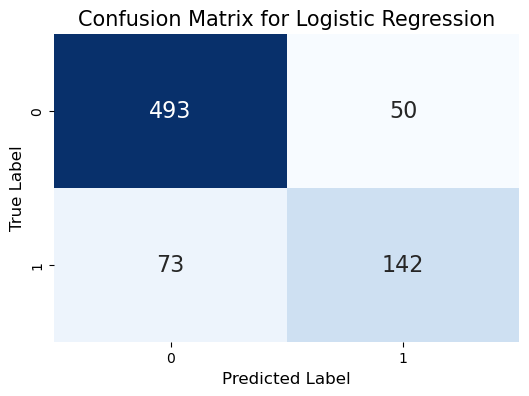

In [11]:
# Logistic Regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Making predictions
y_pred_log = log_reg.predict(X_test_scaled)

# Evaluating the Logistic Regression model
accuracy_log = accuracy_score(y_test, y_pred_log)
precision_log = precision_score(y_test, y_pred_log)
recall_log = recall_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log)

print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_log}")
print(f"Precision: {precision_log}")
print(f"Recall: {recall_log}")
print(f"F1 Score: {f1_log}")

# Plot for Logistic Regression
plot_confusion_matrix(y_test, y_pred_log, 'Logistic Regression')

Random Forest Classifier Results:
Accuracy: 0.9934036939313984
Precision: 1.0
Recall: 0.9767441860465116
F1 Score: 0.9882352941176471


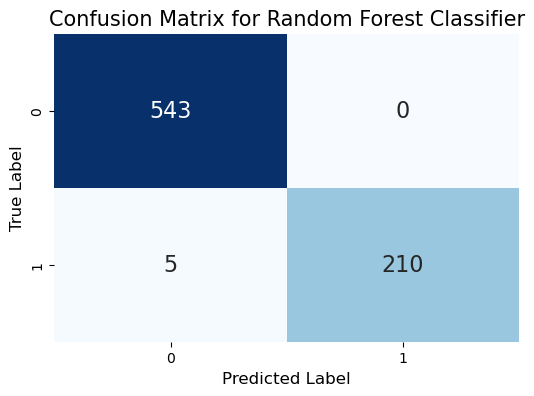

In [12]:
# Random Forest Classifier model
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_scaled, y_train)

# Making predictions
y_pred_rf = rf_clf.predict(X_test_scaled)

# Evaluating the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("Random Forest Classifier Results:")
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1 Score: {f1_rf}")

# Plot for Random Forest
plot_confusion_matrix(y_test, y_pred_rf, 'Random Forest Classifier')

In [13]:
print("\n--- Performance Comparison ---")
print(f"Logistic Regression - Accuracy: {accuracy_log}, Precision: {precision_log}, Recall: {recall_log}, F1 Score: {f1_log}")
print(f"Random Forest Classifier - Accuracy: {accuracy_rf}, Precision: {precision_rf}, Recall: {recall_rf}, F1 Score: {f1_rf}")

# Display detailed classification report for both models
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log))

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


--- Performance Comparison ---
Logistic Regression - Accuracy: 0.837730870712401, Precision: 0.7395833333333334, Recall: 0.6604651162790698, F1 Score: 0.6977886977886978
Random Forest Classifier - Accuracy: 0.9934036939313984, Precision: 1.0, Recall: 0.9767441860465116, F1 Score: 0.9882352941176471

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       543
           1       0.74      0.66      0.70       215

    accuracy                           0.84       758
   macro avg       0.81      0.78      0.79       758
weighted avg       0.83      0.84      0.83       758


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       543
           1       1.00      0.98      0.99       215

    accuracy                           0.99       758
   macro avg       1.00      0.99      0.99       758
weighted avg      